In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# Convergence of numerical SDE methods


## ODE methods - A very brief recap

For ODE methods, when we talk about order of convergence $p$, we mean loosly speaking that there exists a constant $K$, such that for sufficiently small $\Delta t$, we have

$$ \left| x_n(\Delta t) - x(t_n) \right| < K \Delta t^p, $$

where $x_n(\Delta t)$ is the numerical solution at time $t_n$, calculated with timestep $\Delta t$, and $x(t_n)$ is the true solution at time $t_n$.

(Note: $x_n(\Delta t) - x(t_n)$ is called the _global error_. Strictly speaking, the order of an ODE method is defined in terms of the _local error_, i.e., the error in a single step. A method is of order $p$ if the local error scales as $\Delta t^{p+1}$. Then the global error scales as $\Delta t^p$, since the number of steps scales as $1/\Delta t$. See, e.g., Harier, Nørsett & Wanner, pp. 156-157: https://link.springer.com/book/10.1007/978-3-540-78862-1)



## SDE methods

For SDE methods, we have two different types of convergence:
* Weak convergence, also called convergence in distribution
* Strong convergence, also called pathwise convergence

### Weak convergence

If an SDE method has weak convergence of order $\gamma$, then for sufficiently small $\Delta t$, we have that

$$ \left| \left\langle g\big(X_n(\Delta t)\big) \right\rangle - \left\langle g\big( X(t_n) \big) \right\rangle \right| < K \Delta t^\gamma. $$

Here, $X_n(\Delta t)$ is the numerical solution at time $t_n$, calculated with timestep $\Delta t$, $X(t_n)$ is the true solution at time $t_n$, $g(x)$ is a $2(\gamma+1)$ times differentiable function of at most polynomial growth, and $K$ is a constant. See page 326--327 of Kloeden & Platen for additional details.


Possible options of the function $g(x)$ incude $g(x)=x$, $g(x)=(x - \mu)^2$, etc. Hence weak convergence means that

$$ \left| \left\langle X_n(\Delta t) \right\rangle - \left\langle  X(t_n) \right\rangle \right| < K \Delta t^\gamma, $$

i.e., the mean (expectation value) of the numerical solution converges to the mean of the true solution, and

$$ \left| \left\langle (X_n(\Delta t) - \mu)^2 \right\rangle - \left\langle  (X(t_n)-\mu)^2 \right\rangle \right| < K \Delta t^\gamma, $$

i.e., the variance of the numerical solution converges to the variance of the true solution, etc.

In general, the $n$-th moment of a random variable $X$ is given by $\langle X^n \rangle$. A distribution is uniquely defined by its moments. Since weak convergence implies that all the moments converge, weak convergence means that the distribution of the numerical solution converges to the correct distribution. Hence, this is also called convergence in distribution.


### Strong convergence

If an SDE method has strong convergence of order $\gamma$, then for sufficiently small $\Delta t$, we have that

$$ \left| \left\langle X_n(\Delta t) - X(t_n) \right\rangle \right| < K \Delta t^\gamma. $$

Here, $X_n(\Delta t)$ is the numerical solution at time $t_n$, calculated with timestep $\Delta t$, $X(t_n)$ is the true solution at time $t_n$, and $K$ is a constant. See page 323 of Kloeden & Platen for additional details.

Strong convergence means that each individual solution (also called a sample path) converges to the correct solution, for a given realisation of $W_t$. Hence this is also called pathwise convergence.


## Convergence of the Euler-Maruyama method

The Euler-Maruyama method has
* Order of convergence 1 in the weak sense
* Order of convergence 1/2 in the strong sense

Below, we illustrate this numerically, using the SDE for geometric Brownian motion that we saw in Lecture 2.

In [6]:
# An SDE solver

def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

def solve_SDE(X0, tmax, dt, a, b, solver, W=None):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # Confirm that dt evenly divides tmax (to reasonable precision):
    assert ((Nt-1)*dt - tmax) < 1e-14
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in range(1, Nt):
        # Call solver, with pre-computed W if available
        if W is None:
            X[n,:] = solver(X[n-1,:], t, dt, a, b)
        else:
            # Obtain increment from pre-computed Wt
            dW = W[n] - W[n-1]
            X[n,:] = solver(X[n-1,:], t, dt, a, b, dW=dW)
        t += dt
    return X

## Weak convergence of Euler-Maruyama

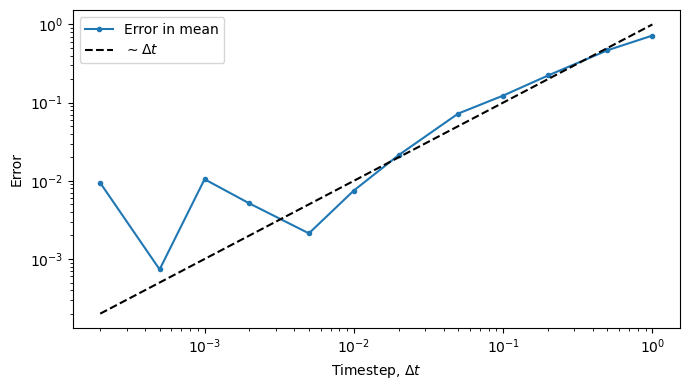

In [11]:
a_ = 1
b_ = 1
X0_ = 1

# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 100000
X0 = X0_ * np.ones(Np)
# Integration time
Tmax = 1
# timestep

# Solve for different timesteps, and calculate the mean and variance
timesteps = np.array([0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
mean_list = np.zeros_like(timesteps)

for i, dt in enumerate(timesteps):
    X = solve_SDE(X0, Tmax, dt, a, b, EM)
    mean_list[i] = np.mean(X[-1, :])

# Plot the difference between the observed and expected mean
mean = X0_*np.exp(a_*Tmax)

mean_error = np.abs(mean_list - mean)

fig = plt.figure(figsize=(7,4))
plt.plot(timesteps, mean_error, marker='.', label='Error in mean')
plt.plot(timesteps, timesteps, '--', c='k', label=('$\sim \Delta t$'))
plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('Error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

## Why does the error appear to be dominated by noise for small timesteps?

Because of the sample error (Monte Carlo error).

The error we measure above has two contributions: The error due to finite timestep, which we expect to converge as $\Delta t$, and the sample error due to finite number of samples, which (from the Central Limit Theorem) we expect to converge as $1/\sqrt(N_p)$ where $N_p$ is number of samples. Hence the error in the sample mean in this case behaves approximately as

$$ E(N_p, \Delta t) \sim \mathcal{O}\left(1/\sqrt{N_p}\right) + K \Delta t, $$

where $K$ is a constant, as seen in the definition of weak convergence. From the Lindeberg-Lévy CLT (see Lecture 1), we can estimate more precisely how the error scales with number of samples:

If $E_{N_p} = \mu - \mu_{N_p}$, where $\mu$ is the *true* mean of the distribution (which will often be unknown). Then the Lindeberg-Lévy CLT says that the distribution of the error, $E_{N_p}$ in the sample mean is given by

$$ E_{N_p} \sim  \frac{1}{\sqrt{{N_p}}} \mathcal{N}(0, \sigma^2), $$

where $\mathcal{N}(0, \sigma^2)$ is a Gaussian distribution with zero mean and variance $\sigma^2$, and $\sigma^2$ is the (usually unknown) variance of the true distribution.

In general, we won't know the variance of the true distribution, but we can use the variance of our samples as an approximation. Below, we show the same convergence plot as above, but with a "noise floor" indicated by

$$ E(N_p) = \sqrt{\frac{\sigma^2_{N_p}}{N_p}} $$,

where $\sigma^2_{N_p}$ is the observed variance of the $N_p$ solutions (using the solutions with the shortest timestep, as presumably the most accurate approximation to the true variance).

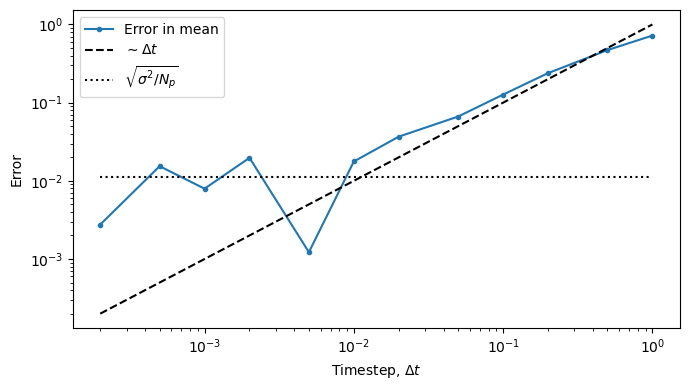

In [15]:
a_ = 1
b_ = 1
X0_ = 1

# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 100000
X0 = X0_ * np.ones(Np)
# Integration time
Tmax = 1
# timestep

# Solve for different timesteps, and calculate the mean and variance
timesteps = np.array([0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
mean_list = np.zeros_like(timesteps)
var_list = np.zeros_like(timesteps)

for i, dt in enumerate(timesteps):
    X = solve_SDE(X0, Tmax, dt, a, b, EM)
    mean_list[i] = np.mean(X[-1, :])
    var_list[i] = np.var(X[-1,:])

# Plot the difference between the observed and expected mean
mean = X0_*np.exp(a_*Tmax)

mean_error = np.abs(mean_list - mean)

fig = plt.figure(figsize=(7,4))
plt.plot(timesteps, mean_error, marker='.', label='Error in mean')
plt.plot(timesteps, timesteps, '--', c='k', label=('$\sim \Delta t$'))

# Plot "noise floor" (which is constant, independent of timestep)
plt.plot(timesteps, np.sqrt(var_list[0]/Np)*np.ones_like(timesteps), ':', c='k', label=('$\sqrt{\sigma^2/N_p}$'))

plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('Error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

### Some remarks about weak convergence

* It may be useful to think about both timestep and number of samples, and perhaps make a plot like the above.
* In the case above, we will not gain accuracy by using a timestep smaller than about $10^{-2}$, unless we also increase number of samples.
* Due to the slow $1/\sqrt{N_p}$ convergence with number of samples, we may potentially need a lot of samples.
* Since samples are independent, the problem is trivially parallelisable, meaning we can run independent copies of the same program to generate more samples. We can even run additional samples later, if we realise later we need better accuracy.


## Strong convergence of Euler-Maruyama

# References

Maruyama, G., Continuous Markov processes and stochastic equations. _Rend. Circ. Mat. Palermo_ 4, 48–90 (1955). https://doi.org/10.1007/BF02846028